In [1]:
from qiskit.circuit import Parameter
from qiskit import (QuantumRegister, ClassicalRegister,
                    QuantumCircuit, Aer, execute)
from qiskit.circuit.library import (
    YGate, CYGate, CRYGate, RYGate, XGate, CXGate, CRXGate, RXGate,
    ZGate, CZGate, CRZGate, RZGate)
import numpy as np
from itertools import combinations
from qiskit.quantum_info import state_fidelity as distance
from scipy.optimize import minimize
from qiskit.quantum_info import Pauli
from qiskit.extensions import UnitaryGate as ug
import itertools
import functools
import numba
from scipy.sparse import diags


import matplotlib.pyplot as plt

In [2]:
def get_u(p1,p2,label=None):
    q=QuantumRegister(2)
    anc=QuantumRegister(1)
    c=QuantumCircuit(q,anc)
    c.cry(p2,anc,q[0])
    c.ry(p1,q[0])
    c.cnot(q[0],q[1])
    return c.to_gate(label=label)
c=QuantumCircuit(3)
c.append(get_u(2,3),[0,1,2])
c.decompose().draw()

┌───────┐┌───────┐     
q_0: ┤ RY(3) ├┤ RY(2) ├──■──
     └───┬───┘└───────┘┌─┴─┐
q_1: ────┼─────────────┤ X ├
         │             └───┘
q_2: ────■──────────────────

In [3]:
def get_two_qubit_pqc(n,depth=1,label="2-qubit-PQC"):
    two_qbit_pairs_1=[list(i) for i in [np.arange(n)[i:i + 2] for i in range(0, len(np.arange(n)), 2)] if len(i)==2 ]
    two_qbit_pairs_2=[list(i) for i in [np.arange(n)[i:i + 2] for i in range(1, len(np.arange(n)), 2)] if len(i)==2 ]
    q=QuantumRegister(n,'q')
    anc=QuantumRegister(1,"anc")
    c=QuantumCircuit(anc,q)
    for i in two_qbit_pairs_1:
        p1=Parameter("t_{}{}_{}".format(i[0],i[1],depth))
        p2=Parameter("opt_{}{}_{}".format(i[0],i[1],depth))
        qubits=[q[i[0]],q[i[1]]]
        qubits.append(anc)
        c.append(get_u(p1,p2,label="U"),qubits)

    for i in two_qbit_pairs_2:
        p1=Parameter("t_{}{}_{}".format(i[0],i[1],depth))
        p2=Parameter("opt_{}{}_{}".format(i[0],i[1],depth))
        qubits=[q[i[0]],q[i[1]]]
        qubits.append(anc)
        c.append(get_u(p1,p2,label="U"),qubits)
    return c.to_gate(label=label)

In [4]:
def get_circuit(n=4,depth=2,Imaginary=True):
    q=QuantumRegister(n,'q')
    anc=QuantumRegister(1,"anc")
    c=QuantumCircuit(anc,q)
    c.h(anc)
    if Imaginary:
        c.s(anc)
    c.barrier()
    for i in range(depth):
        pqc=get_two_qubit_pqc(n,depth=i,label=f"2-qubit-PQC-{i+1}")
        c.append(pqc,range(n+1))
        c.barrier()
    c.h(anc)
    return c
c=get_circuit(n=4,depth=2,Imaginary=True)
c.draw()

┌───┐┌───┐ ░ ┌────────────────┐ ░ ┌────────────────┐ ░ ┌───┐
anc_0: ┤ H ├┤ S ├─░─┤0               ├─░─┤0               ├─░─┤ H ├
       └───┘└───┘ ░ │                │ ░ │                │ ░ └───┘
  q_0: ───────────░─┤1               ├─░─┤1               ├─░──────
                  ░ │                │ ░ │                │ ░      
  q_1: ───────────░─┤2 2-qubit-PQC-1 ├─░─┤2 2-qubit-PQC-2 ├─░──────
                  ░ │                │ ░ │                │ ░      
  q_2: ───────────░─┤3               ├─░─┤3               ├─░──────
                  ░ │                │ ░ │                │ ░      
  q_3: ───────────░─┤4               ├─░─┤4               ├─░──────
                  ░ └────────────────┘ ░ └────────────────┘ ░

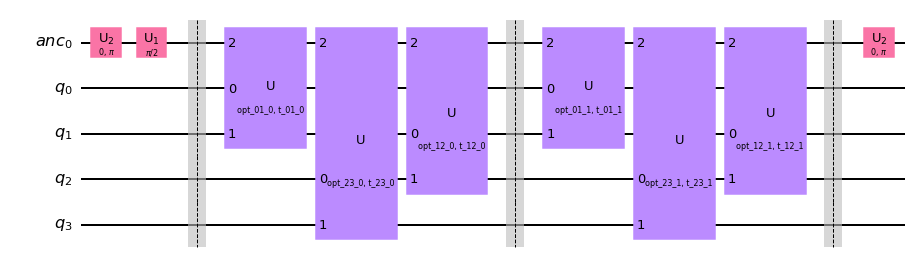

In [5]:
c.decompose().draw('mpl')

In [476]:
from qiskit.aqua.operators import PauliExpectation, CircuitSampler, StateFn,CircuitStateFn,AerPauliExpectation,ExpectationFactory
from qiskit.aqua.operators import X, Y, Z, I

def get_exp(H,circ):
    psi=CircuitStateFn(circ)
    backend = Aer.get_backend('statevector_simulator') 
    measurable_expression = StateFn(H, is_measurement=True).compose(psi) 
    expectation = AerPauliExpectation().convert(measurable_expression)
    sampler = CircuitSampler(backend).convert(expectation)  
    return sampler.eval().real
def get_random_param_dict(circ,seed=4):
    values={}
    np.random.seed(seed)
    for i in sorted(circ.parameters,key=lambda x:x.name):
        values[i]=np.random.uniform(0,np.pi)
    return values

def set_angle(circ,angle):
    values={}
    for j,i in enumerate(sorted(circ.parameters,key=lambda x:x.name)):
        values[i]=angle[j]
    return circ.assign_parameters(values).copy() 
def get_exp_angle(H,circ,angle):
    calc_circ=set_angle(circ,angle)
    return get_exp(H,calc_circ)

In [375]:
from qiskit.aqua.operators import PauliExpectation, CircuitSampler, StateFn,CircuitStateFn,AerPauliExpectation,ExpectationFactory
from qiskit.aqua.operators import X, Y, Z, I

def get_exp(H,circ):
    psi=CircuitStateFn(circ)
    backend = Aer.get_backend('statevector_simulator') 
    measurable_expression = StateFn(H, is_measurement=True).compose(psi) 
    expectation = AerPauliExpectation().convert(measurable_expression)
    sampler = CircuitSampler(backend).convert(expectation)  
    return sampler.eval().real
def get_random_param_dict(circ,seed=4):
    values={}
    np.random.seed(seed)
    for i in sorted(circ.parameters,key=lambda x:x.name):
        values[i]=np.random.uniform(0,np.pi)
    return values

c=get_circuit(n=4,depth=2,Imaginary=True)

vals_img=[]
A=np.linspace(-1*np.pi,1*np.pi,19)
seed=5

v=get_random_param_dict(c,seed=seed)

for angle in A:
    v[list(v.keys())[-1]]=angle
    calc_circ=c.assign_parameters(v).copy()
    H=(3 * Z^X^Y^Y^Y)
    vals_img.append(get_exp(H,calc_circ))


c=get_circuit(n=4,depth=2,Imaginary=False)

vals_real=[]
v=get_random_param_dict(c,seed=seed)
for angle in A:
    v[list(v.keys())[-1]]=angle
    calc_circ=c.assign_parameters(v).copy()
    H=(3 * Z^X^Y^Y^Z)
    vals_real.append(get_exp(H,calc_circ))


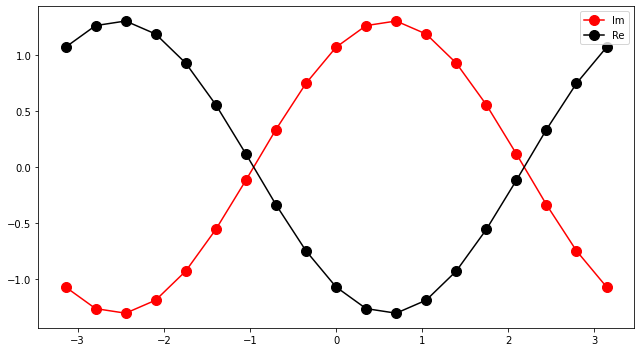

In [376]:
fig,ax=plt.subplots(1,1,figsize=(9,5))
ax.plot(A,vals_img,marker="o",c="r",label="Im",markersize=10)
ax.plot(A,vals_real,marker="o",c="k",label="Re",markersize=10)
ax.legend()
plt.tight_layout()


In [6]:
def get_diff_mat(N, a=1, b=1, dx=1, boundary=1):
    '''
    Returns the differential oppertor matrix for equation given by a(d/dx)+b(d/dx)^2 for log(N) qubits discritized by dx
    '''
    D = a*diags([1, -2, 1], [-1, 0, 1], shape=(N, N))/dx
    D = D.toarray()
    D[0][0] = D[-1][-1] = -boundary
    return D
n=3
D=get_diff_mat(2**n,dx=10,boundary=1/10)

In [7]:
from qiskit.aqua.operators.primitive_ops import MatrixOp 
from qiskit.aqua.operators.primitive_ops import PauliOp
op=MatrixOp(np.exp(D))
for j,i in enumerate (op.to_pauli_op().oplist): print(f"term {j}",i.primitive)
HI=PauliOp(Pauli.from_label("I"*n), coeff=1.0)

term 0 III
term 1 IIX
term 2 IXI
term 3 IXX
term 4 IYY
term 5 IZZ
term 6 XII
term 7 XIX
term 8 XXI
term 9 XXX
term 10 XYY
term 11 YXY
term 12 YYX
term 13 ZIZ
term 14 ZZI


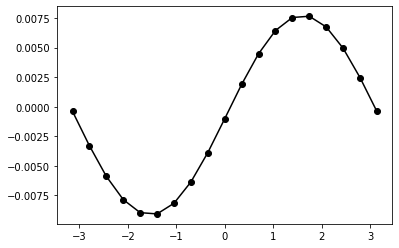

In [489]:
c=get_circuit(n=n,depth=2,Imaginary=False)

vals_img=[]
A=np.linspace(-1*np.pi,1*np.pi,19)
seed=5

v=get_random_param_dict(c,seed=seed)

for angle in A:
    v[list(v.keys())[0]]=angle
    H=op.to_pauli_op().oplist[2]
    calc_circ=c.assign_parameters(v).copy() 
    vals_img.append(get_exp(H,calc_circ))
plt.plot(A,vals_img,marker="o",c="k")

In [479]:
from qiskit.aqua.operators.primitive_ops import MatrixOp 
from qiskit.aqua.operators.primitive_ops import PauliOp

def get_diff_mat(N, a=1, b=1, dx=1, boundary=1):
    '''
    Returns the differential oppertor matrix for equation given by a(d/dx)+b(d/dx)^2 for log(N) qubits discritized by dx
    '''
    D = a*diags([1, -2, 1], [-1, 0, 1], shape=(N, N))/dx
    D = D.toarray()
    D[0][0] = D[-1][-1] = -boundary
    return D
n=3
D=get_diff_mat(2**n,dx=10,boundary=1/10)

op=MatrixOp(np.exp(D))
# for j,i in enumerate (op.to_pauli_op().oplist): print(f"term {j}",i.primitive)
HI=PauliOp(Pauli.from_label("I"*n), coeff=1.0)

In [29]:
def set_angle(circ,angle):
    values={}
    for j,i in enumerate(sorted(circ.parameters,key=lambda x:x.name)):
        values[i]=angle[j]
    return circ.assign_parameters(values).copy() 
def get_exp_angle(H,circ,angle):
    calc_circ=set_angle(circ,angle)
    return get_exp(H,calc_circ)

In [144]:

def iter_theta(position,H,circuit,angle,theta_d=0):
    angle[position]=theta_d
    fd=get_exp_angle(H,circuit,angle)
    angle[position]+=np.pi/2
    fd_pi=get_exp_angle(H,circuit,angle)
    return np.pi/2 - np.arctan(np.nan_to_num([fd/fd_pi],1)[0]) + theta_d
    # return np.pi/2 - np.arctan2(fd,fd_pi) + theta_d


In [477]:
theta_d=0
H=op.to_pauli_op().oplist[3]
circuit=get_circuit(n=4,depth=2,Imaginary=True)
angle=np.random.uniform(0,2*np.pi,len(circuit.parameters))
opt_angle={}
for j in [0,1,2,3,4,5]:
    argmax=iter_theta(position=j,H=H,circuit=circuit,angle=angle,theta_d=theta_d)
    opt_angle[j]=(argmax)
    print(j,argmax)

0 0.7831936809142034
1 0.7867153079158438
2 0.7874610528222209
3 0.7095808337480509
4 0.7853981633974481
5 0.7853981633974483


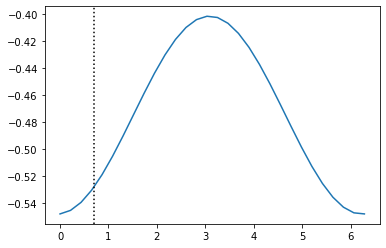

In [478]:
angle_mesh=np.linspace(0,2*np.pi,30)
val=[]
pos=3
for theta_d in angle_mesh:
    angle[pos]=theta_d
    val.append(get_exp_angle(H,circuit,angle))
plt.plot(angle_mesh,val)
plt.axvline(opt_angle[pos],c="k",ls=":")
plt.show()